In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from src.enums import Shape
from src.geometry import (
    estimate_intrinsic_from_homography,
    recover_pose_from_homography,
)
from src.plotting import draw_3d_shape

In [3]:
# Load template and images
template_path = '../assets/templates/template_00.jpg'
image_paths = [
    '../assets/images/image_00.jpg',
    '../assets/images/scene_03.jpg',
    '../assets/images/image_02.jpg',
]

template = cv2.cvtColor(cv2.imread(template_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
images = [cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB) for image_path in image_paths]

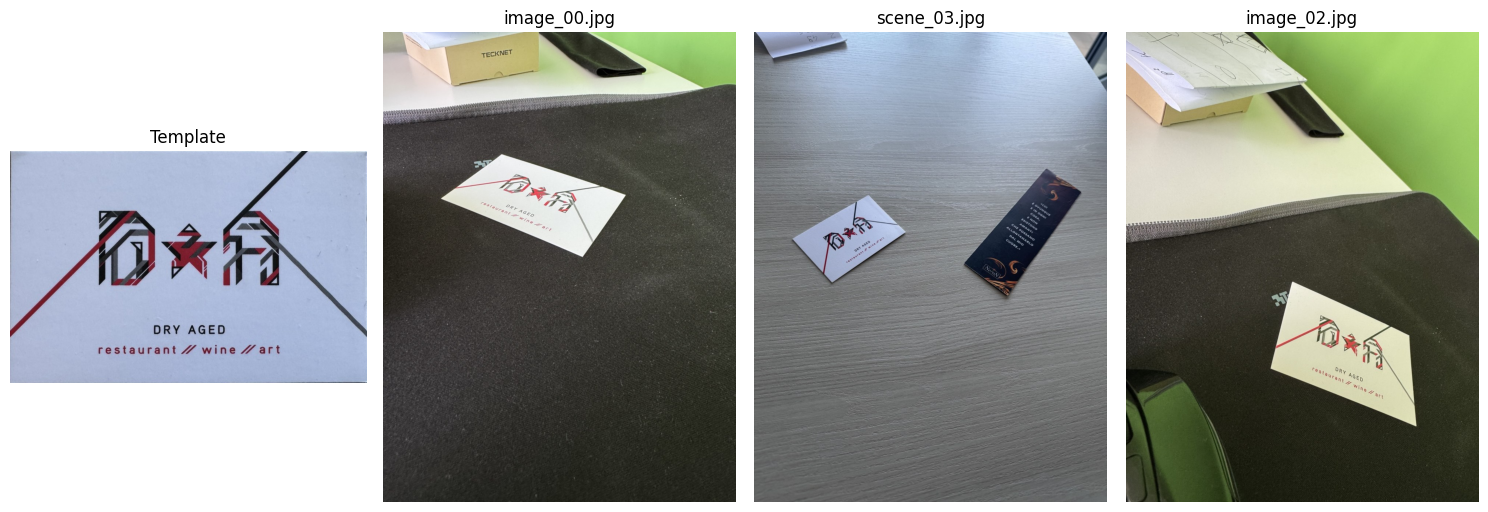

In [4]:
# Plot template and images on the same line
fig, axes = plt.subplots(1, len(images) + 1, figsize=(15, 5))
axes[0].imshow(template)
axes[0].set_title('Template')
axes[0].axis('off')
for ax, image, image_path in zip(axes[1:], images, image_paths):
    ax.imshow(image)
    ax.set_title(image_path.split('/')[-1])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Perform feature extraction on template and images using SIFT
sift = cv2.SIFT_create()
keypoints_template, descriptors_template = sift.detectAndCompute(template, None)
keypoints_images = []
descriptors_images = []
for image in images:
    keypoints, descriptors = sift.detectAndCompute(image, None)
    keypoints_images.append(keypoints)
    descriptors_images.append(descriptors)

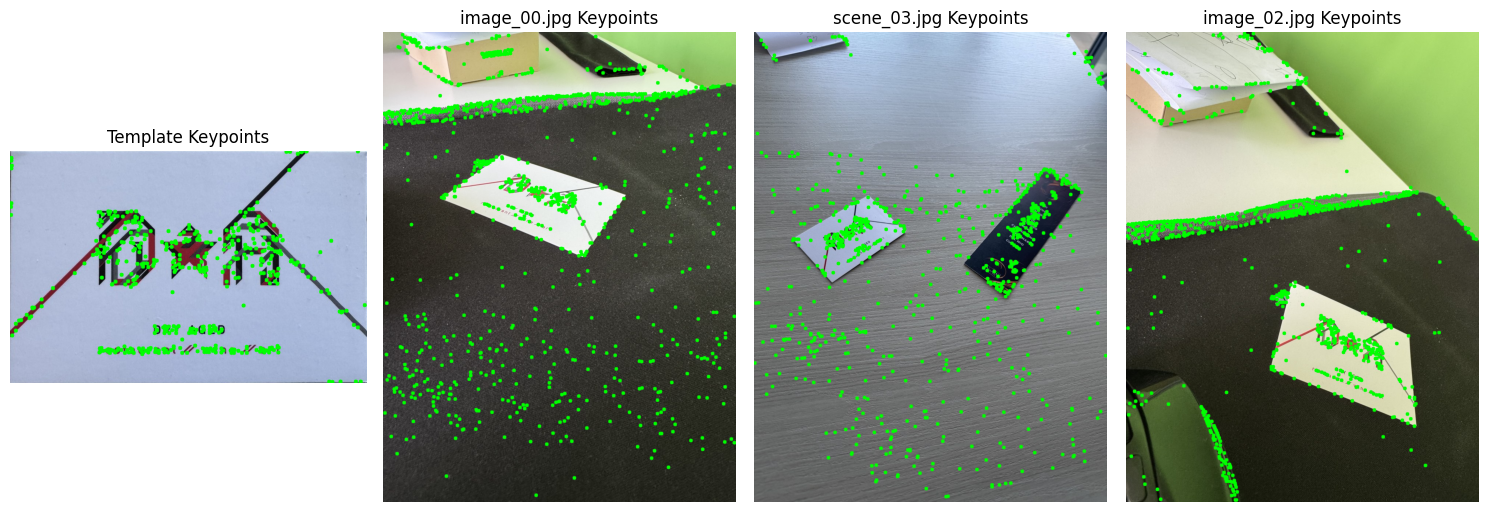

In [6]:
# Display the keypoints on the template and images
def draw_keypoints(image, keypoints):
    image_with_keypoints = image.copy()
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(image_with_keypoints, (x, y), 5, (0, 255, 0), -1)
    return image_with_keypoints

fig, axes = plt.subplots(1, len(images) + 1, figsize=(15, 5))
axes[0].imshow(draw_keypoints(template, keypoints_template))
axes[0].set_title('Template Keypoints')
axes[0].axis('off')
for ax, image, keypoints, image_path in zip(axes[1:], images, keypoints_images, image_paths):
    ax.imshow(draw_keypoints(image, keypoints))
    ax.set_title(image_path.split('/')[-1] + ' Keypoints')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# Print the number of keypoints detected in each image
print(f"Number of keypoints in template: {len(keypoints_template)}")
for i, (image_path, keypoints) in enumerate(zip(image_paths, keypoints_images)):
    print(f"Number of keypoints in {image_path.split('/')[-1]}: {len(keypoints)}")

Number of keypoints in template: 616
Number of keypoints in image_00.jpg: 1303
Number of keypoints in scene_03.jpg: 894
Number of keypoints in image_02.jpg: 1114


In [8]:
# Perform matching using BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = []
for i, (descriptors_image, keypoints_image) in enumerate(zip(descriptors_images, keypoints_images)):
    match = bf.match(descriptors_template, descriptors_image)
    matches.append(match)
    matches[i] = sorted(matches[i], key=lambda x: x.distance)
    print(f"Number of matches in {image_paths[i].split('/')[-1]}: {len(matches[i])}")

Number of matches in image_00.jpg: 167
Number of matches in scene_03.jpg: 171
Number of matches in image_02.jpg: 189


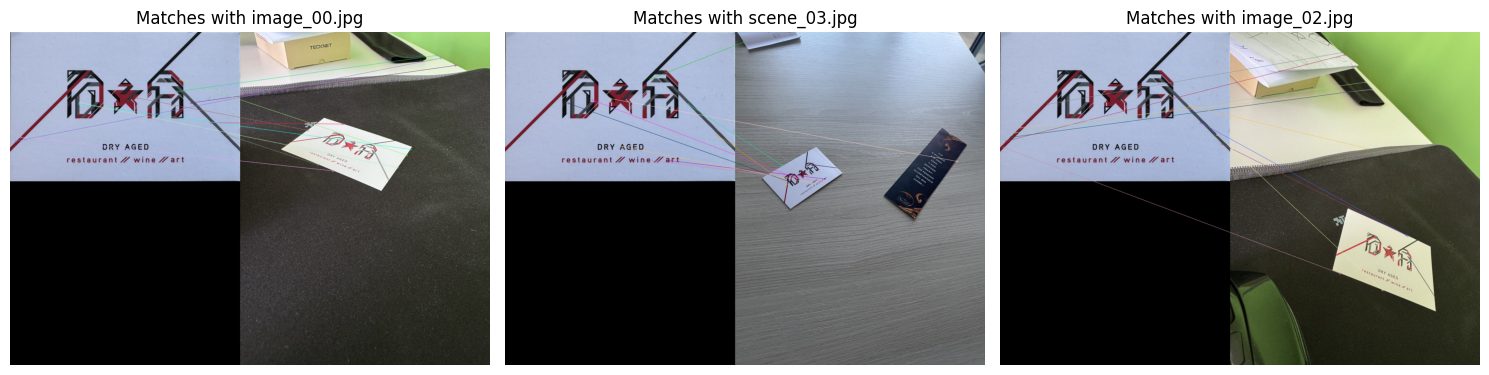

In [9]:
# Draw the matches
def draw_matches(image1, keypoints1, image2, keypoints2, matches):
    image_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return image_matches

fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
for ax, image, keypoints, match, image_path in zip(axes, images, keypoints_images, matches, image_paths):
    ax.imshow(draw_matches(template, keypoints_template, image, keypoints, match))
    ax.set_title('Matches with ' + image_path.split('/')[-1])
    ax.axis('off')
plt.tight_layout()
plt.show()

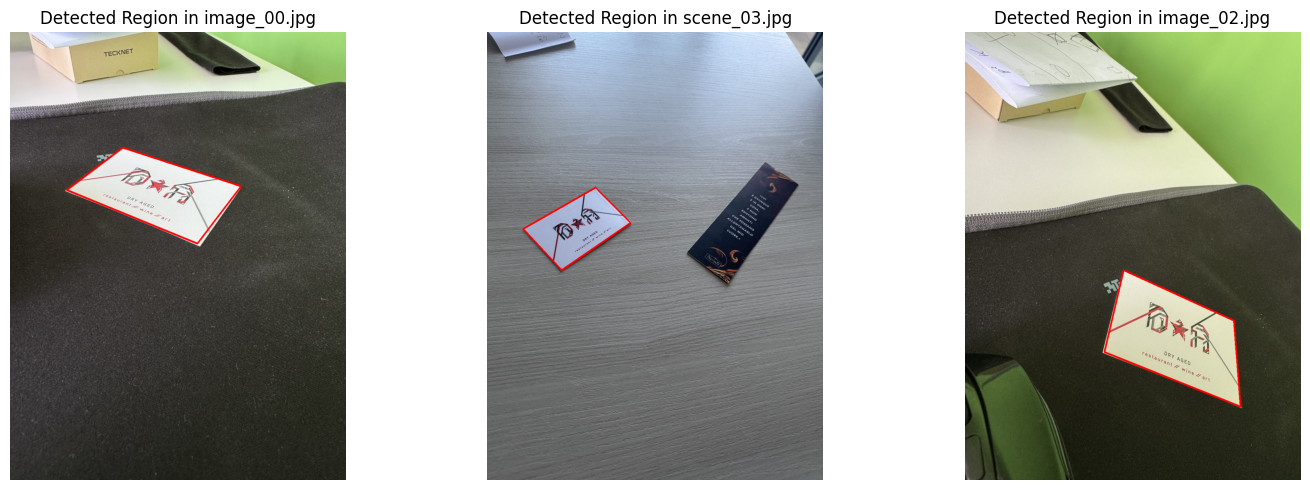

In [10]:
# Compute the homography matrix for each image
def compute_homography(matches, keypoints1, keypoints2):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return M, mask

# Draw a rectangle in each image to show the detected region
def draw_rectangle(image, M):
    h, w = template.shape[:2]
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)
    image_with_rectangle = cv2.polylines(image.copy(), [np.int32(dst)], True, (255, 0, 0), 3)
    return image_with_rectangle

fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
for ax, image, keypoints, match, image_path in zip(axes, images, keypoints_images, matches, image_paths):
    M, mask = compute_homography(match, keypoints_template, keypoints)
    ax.imshow(draw_rectangle(image, M))
    ax.set_title('Detected Region in ' + image_path.split('/')[-1])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [11]:
# Only work with image_01 for now
image_index = 1
image = images[image_index]

# Compute the homography matrix for image_01
H, mask = compute_homography(matches[image_index], keypoints_template, keypoints_images[image_index])

# Define known camera intrinsics
ux = image.shape[1] / 2
uy = image.shape[0] / 2

# Estimate K using the homography matrix
K = estimate_intrinsic_from_homography(H, (ux, uy))

# Recover the pose using the homography matrix and camera intrinsics
R, t = recover_pose_from_homography(H, K)

[WARN] Original homography columns may not be orthogonal: normalized dot = 0.537
[INFO] f_squared (orthogonality constraint): 1596551.4983859716
[INFO] f_squared (norm constraint): 523180.48055504163
[INFO] Using average of both estimates (they are consistent)


In [12]:
def project_points_test(points_3d, R, t, K, dist_coeffs = None):
    # Transform to camera coordinates
    points_cam = (R @ points_3d.T).T + t
    
    # Perspective projection
    x_norm = points_cam[:, 0] / points_cam[:, 2]
    y_norm = points_cam[:, 1] / points_cam[:, 2]
    
    # Apply distortion (simplified radial only)
    if dist_coeffs is None:
        dist_coeffs = np.zeros(2)  # No distortion
    r2 = x_norm**2 + y_norm**2
    radial_factor = 1 + dist_coeffs[0]*r2 + dist_coeffs[1]*r2**2
    x_dist = x_norm * radial_factor
    y_dist = y_norm * radial_factor
    
    # Apply camera matrix
    u = K[0,0] * x_dist + K[0,2]
    v = K[1,1] * y_dist + K[1,2]
    
    return np.column_stack([u, v])

In [13]:
from plotting import generate_corners_from_shape


def draw_3d_axes_test(
    image: np.ndarray,
    R: np.ndarray,
    t: np.ndarray,
    K: np.ndarray,
    template_corners_3d: np.ndarray | None = None,
    template_shape: tuple[int, int] | None = None,
    anchor: str = 'origin',
    axis_scale: float = 0.5,
    thickness: int = 10,
    flip_z: bool = True,
) -> np.ndarray:
    """
    Project and draw a 3D coordinate axes frame onto an image.

    This function allows specifying the planar template either via explicit 3D corners
    or by providing a rectangular shape (width, height) in pixel units. The axes origin
    can be anchored at the template's first corner or its centroid.
    The axes (X, Y, Z) are color-coded as (red, green, blue) respectively.

    Args:
        image (np.ndarray): Input RGB or grayscale image. A copy is returned with axes drawn.
        R (np.ndarray): Rotation matrix from world to camera (3×3).
        t (np.ndarray): Translation vector from world to camera (3,).
        K (np.ndarray): Camera intrinsic matrix (3×3).
        template_corners_3d (np.ndarray, optional): Template coordinates of the template's planar corners (in pixels),
            shape (N, 3). Overrides template_shape if provided.
        template_shape (tuple[int, int], optional): Width and height of the planar template in pixel units.
            Used only if template_corners_3d is not provided.
        anchor (str): 'origin' to anchor at the first corner, 'center' to anchor at centroid. Defaults to 'center'.
        axis_scale (float): Fraction of the template's diagonal in image pixels used as axis length. Defaults to 0.5.
        thickness (int): Line thickness in pixels. Defaults to 10.
        flip_z (bool): If True, draw the Z-axis toward the camera (negative world Z direction). Defaults to True.

    Returns:
        np.ndarray: Copy of `image` with the 3D axes drawn in RGB (X=red, Y=green, Z=blue).

    Raises:
        ValueError: If the input shapes are incorrect or if neither template_corners_3d nor template_shape is provided.
    """
    # 1. Validate inputs
    if R.shape != (3, 3):
        raise ValueError(f"Rotation matrix R must be of shape (3, 3), got {R.shape}.")
    if t.shape != (3,):
        raise ValueError(f"Translation vector t must be of shape (3,), got {t.shape}.")
    if K.shape != (3, 3):
        raise ValueError(f"Camera matrix K must be of shape (3, 3), got {K.shape}.")
    if image.ndim not in (2, 3):
        raise ValueError(
            f"Image must be a 2D grayscale or 3D RGB image, got {image.ndim} dimensions."
        )

    # 2. Determine template corners
    if template_corners_3d is not None:
        corners_world = template_corners_3d.reshape(-1, 3)
    elif template_shape is not None:
        corners_world = generate_corners_from_shape(template_shape)
        pass
    else:
        raise ValueError(
            "Either template_corners_3d or template_shape must be provided."
        )

    # 3. Project template corners into image space
    image_corners = project_points_test(corners_world, R, t, K)

    # 4. Compute diagonal of the template in pixels
    diag_pix = np.linalg.norm(image_corners[2] - image_corners[0])

    # 5. Estimate average depth (Z) of the template in camera coordinates
    cam_coords = (R @ corners_world.T + t.reshape(3, 1)).T
    z_mean = np.mean(cam_coords[:, 2])

    # 6. Compute focal length (assume fx ≈ fy)
    f_pix = (K[0, 0] + K[1, 1]) / 2.0

    # 7. Compute axis length in world units
    axis_length = (diag_pix * axis_scale * z_mean) / f_pix

    # 8. Compute axes origin based on anchor
    origin = corners_world[0]

    # 9. Build 3D axes endpoints in world coords
    axes_world = np.vstack(
        [
            origin,
            origin + np.array([axis_length, 0, 0]),
            origin + np.array([0, axis_length, 0]),
            origin + np.array([0, 0, -axis_length if flip_z else axis_length]),
        ]
    )

    # 10. Project axes endpoints into image space
    axes_image = project_points_test(axes_world, R, t, K).astype(int)

    # 11. Ensure the image is in RGB format
    out = image.copy() if image.ndim == 3 else cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # 12. Draw the axes on the image
    origin_pt = tuple(axes_image[0])
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # X=red, Y=green, Z=blue
    for i, col in enumerate(colors, start=1):
        cv2.arrowedLine(out, origin_pt, tuple(axes_image[i]), col, thickness)

    return out

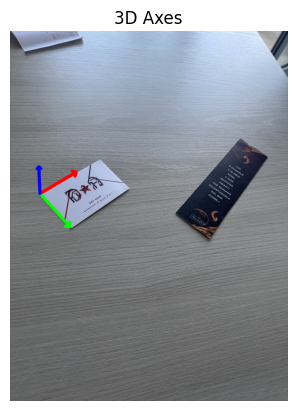

In [14]:
t_shape = template.shape[:2]

# Draw 3D axes
img = draw_3d_axes_test(image, R, t, K, template_shape=t_shape, anchor='origin')

# Plot the image with 3D axes
plt.show()
plt.imshow(img)
plt.title("3D Axes")
plt.axis('off')
plt.show()

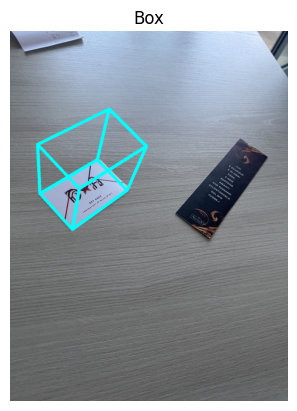

In [15]:
# Draw a box on the template instance
w, h, d = t_shape[1], t_shape[0], t_shape[1]
box_image = draw_3d_shape(image, R, t, K, Shape.BOX, width=w, height=h, depth=d)
plt.imshow(box_image)
plt.title("Box")
plt.axis('off')
plt.show()

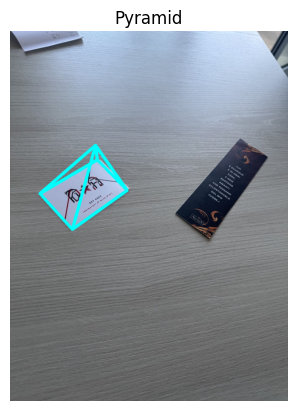

In [16]:
# Draw a pyramid on the template instance
pyramid_image = draw_3d_shape(image, R, t, K, Shape.PYRAMID, width=w, height=h, depth=d)
plt.imshow(pyramid_image)
plt.title("Pyramid")
plt.axis('off')
plt.show()

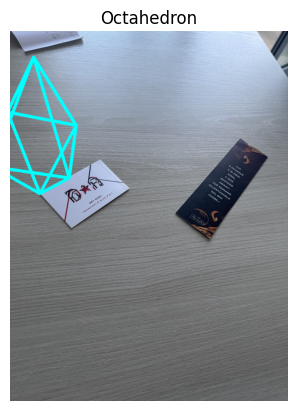

In [17]:
# Draw octahedron on the template instance
octahedron_image = draw_3d_shape(image, R, t, K, Shape.OCTAHEDRON, width=w, height=h, depth=d)
plt.imshow(octahedron_image)
plt.title("Octahedron")
plt.axis('off')
plt.show()

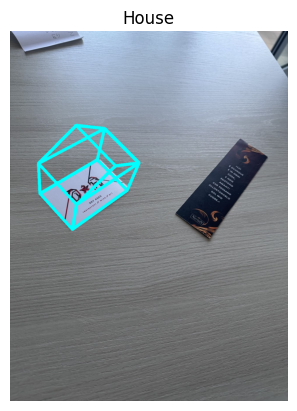

In [18]:
# Draw a house on the template instance
house_image = draw_3d_shape(image, R, t, K, Shape.HOUSE, width=w, height=h, depth=d)
plt.imshow(house_image)
plt.title("House")
plt.axis('off')
plt.show()